In [1]:
import json
import pandas as pd
import numpy as np
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [20]:
with open("PR_comments_commits.json", "r") as f:
    data = json.load(f)
    
df = pd.json_normalize(
    data,
    record_path=['comments'],  # Flatten the 'comments' array
    meta=['pull_request_url'],  # Include the pull request ID
    errors='ignore'
)

In [21]:
df['comment'] = df['comment'].fillna("")
df.head()

,comment_type,user,comment,date,commit_sha,author,commit_message,is_code_owner,author_is_code_owner,pull_request_url
0,Issue,home-assistant[bot],\nHi @fender4645\n\nIt seems you haven't yet s...,2023-09-09T18:53:44Z,None,fender4645,None,False,False,https://github.com/home-assistant/core/pull/10...
1,Review,jbouwh,```suggestion\r\n _LOGGER.debug(\r\...,2023-09-09T21:13:37Z,None,fender4645,None,True,False,https://github.com/home-assistant/core/pull/10...
2,Review,jbouwh,```suggestion\r\n _LOGGER.debug(\r\...,2023-09-10T10:51:46Z,None,fender4645,None,True,False,https://github.com/home-assistant/core/pull/10...
3,NaN,NaN,,2023-09-09T17:56:29Z,dbeaa2d2798b709dc4a126e5d94b3657c6c9c43c,fender4645,Debug message if no detections found or\nno ou...,NaN,False,https://github.com/home-assistant/core/pull/10...
4,NaN,NaN,,2023-09-09T22:14:49Z,5862a57f58db7c18893723b646fd6bc729ca17d0,fender4645,fix formatting,NaN,False,https://github.com/home-assistant/core/pull/10...


In [22]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
text_features = vectorizer.fit_transform(df['comment'])

In [23]:
df['comment_type_encoded'] = LabelEncoder().fit_transform(df['comment_type'].fillna(""))
df['is_code_owner_encoded'] = df['is_code_owner'].fillna(0).astype(int)
df['author_is_code_owner_encoded'] = df['author_is_code_owner'].fillna(0).astype(int)

In [27]:
metadata_features = df[['comment_type_encoded', 'is_code_owner_encoded', 'author_is_code_owner_encoded']].values
combined_features = hstack([text_features, metadata_features])
df.head()

,comment_type,user,comment,date,commit_sha,author,commit_message,is_code_owner,author_is_code_owner,pull_request_url,comment_type_encoded,is_code_owner_encoded,author_is_code_owner_encoded
0,Issue,home-assistant[bot],\nHi @fender4645\n\nIt seems you haven't yet s...,2023-09-09T18:53:44Z,None,fender4645,None,False,False,https://github.com/home-assistant/core/pull/10...,1,0,0
1,Review,jbouwh,```suggestion\r\n _LOGGER.debug(\r\...,2023-09-09T21:13:37Z,None,fender4645,None,True,False,https://github.com/home-assistant/core/pull/10...,2,1,0
2,Review,jbouwh,```suggestion\r\n _LOGGER.debug(\r\...,2023-09-10T10:51:46Z,None,fender4645,None,True,False,https://github.com/home-assistant/core/pull/10...,2,1,0
3,NaN,NaN,,2023-09-09T17:56:29Z,dbeaa2d2798b709dc4a126e5d94b3657c6c9c43c,fender4645,Debug message if no detections found or\nno ou...,NaN,False,https://github.com/home-assistant/core/pull/10...,0,0,0
4,NaN,NaN,,2023-09-09T22:14:49Z,5862a57f58db7c18893723b646fd6bc729ca17d0,fender4645,fix formatting,NaN,False,https://github.com/home-assistant/core/pull/10...,0,0,0


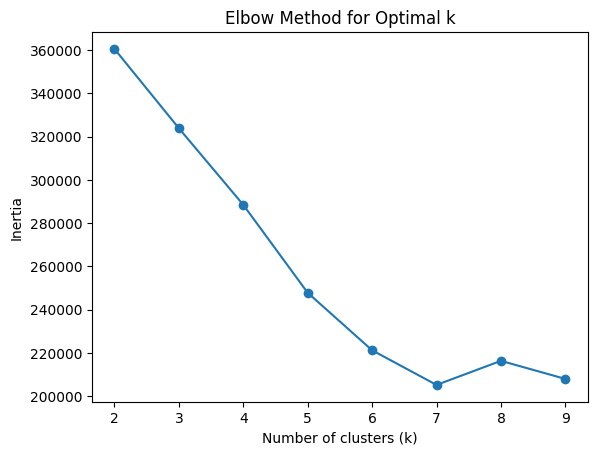

In [28]:
inertia = []
k_values = range(2, 10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(combined_features)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


In [29]:
optimal_k = 6

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(combined_features)

In [30]:
print(df['cluster'].value_counts())

cluster
0    132504
1     86737
4     54127
2     51069
5     33242
3     26933
Name: count, dtype: int64


In [31]:
for cluster in range(optimal_k):
    print(f"\nCluster {cluster}:")
    cluster_data = df[df['cluster'] == cluster]
    print(cluster_data['comment'].head(5))  # Example comments
    print(cluster_data[['comment_type', 'is_code_owner', 'author_is_code_owner']].describe())


Cluster 0:
10    
13    
14    
15    
30    
Name: comment, dtype: object
       comment_type is_code_owner author_is_code_owner
count             0             0               132504
unique            0             0                    1
top             NaN           NaN                 True
freq            NaN           NaN               132504

Cluster 1:
20    Could we maybe implement an `update_attr()` fu...
21                                            Not used?
22    Storing all the alerts with their data in the ...
23    Good point. Could we fire an event when a new ...
24    You could have another sensor with a timestamp...
Name: comment, dtype: object
       comment_type is_code_owner author_is_code_owner
count         86737         86737                86737
unique            1             2                    1
top          Review          True                 True
freq          86737         84153                86737

Cluster 2:
8                                        

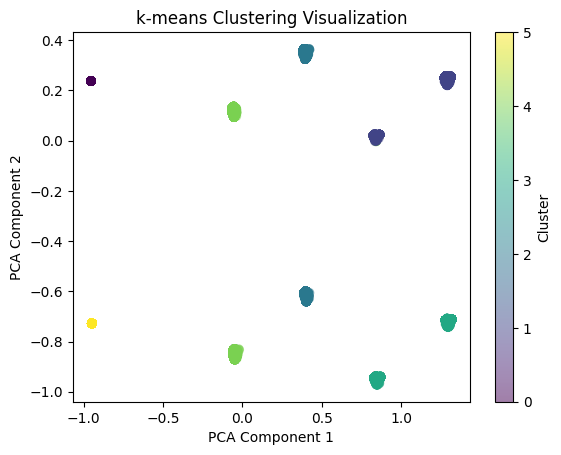

: 

In [32]:
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(combined_features.toarray())


plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=df['cluster'], cmap='viridis', alpha=0.5)
plt.title('k-means Clustering Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()